In [1]:
!pip install pandas

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
!pip install pycocotools

  Using cached Cython-0.29.24-cp39-cp39-macosx_10_9_x86_64.whl (1.9 MB)
Using legacy 'setup.py install' for pycocotools, since package 'wheel' is not installed.
    Running setup.py install for pycocotools ... error
    ERROR: Command errored out with exit status 1:
     command: /usr/local/bin/python3.9 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/jl/2n_w18z54n5c63fvjmkg6xzh00rs05/T/pip-install-b414dsy5/pycocotools_8e7a5362cfcc436d8f6c3f6e0075667a/setup.py'"'"'; __file__='"'"'/private/var/folders/jl/2n_w18z54n5c63fvjmkg6xzh00rs05/T/pip-install-b414dsy5/pycocotools_8e7a5362cfcc436d8f6c3f6e0075667a/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/jl/2n_w18z54n5c63fvjmkg6xzh00rs05/T/pip-

In [3]:
from collections import Counter, defaultdict
import os, sys

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from pycocotools.coco import COCO
import skimage.io as io

ModuleNotFoundError: No module named 'pycocotools'

In [7]:
sys.path.append('/data/raw/train/train2014')
#import coco_dataset

### Global Variables

In [4]:
coco_objects = coco_dataset.coco_objects
coco_objects

{'train': <pycocotools.coco.COCO at 0x10b0660a0>,
 'valid': <pycocotools.coco.COCO at 0x10b014eb0>,
 'test': <pycocotools.coco.COCO at 0x10b066a00>}

### Category Observations
- the same super categories and categories exist across all datasets
- need to confirm if the same number of images per annotation can be found across all splits (train, validation, and test)  

In [5]:
coco = coco_dataset.coco_objects.get('train')
categories = coco.loadCats(coco.getCatIds())

In [6]:
subcategories = [cat['name'] for cat in categories]

In [7]:
categories_consol = defaultdict(dict)

for category_meta in categories:
    categories_consol[category_meta['supercategory']].update({ category_meta['name']: category_meta['id']})

In [8]:
for supercat, subcat_ids in categories_consol.items():
    print(supercat, len(subcat_ids))

person 1
vehicle 8
outdoor 5
animal 10
accessory 5
sports 10
kitchen 7
food 10
furniture 6
electronic 6
appliance 5
indoor 7


In [9]:
categories_consol['animal'].keys()

dict_keys(['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe'])

In [10]:
imgs_per_category = {}

for super_cat, subcat_name_ids in categories_consol.items():
    imgs_per_category[super_cat] = dict()
    for subcat, cat_id in subcat_name_ids.items():
        img_ids = coco.getImgIds(catIds=coco.getCatIds(cat_id))
        num_imgs=len(img_ids)
        imgs_per_category[super_cat][subcat] = dict(
            img_ids=img_ids,
            num_imgs=num_imgs
        )
        print(subcat, num_imgs)

person 82783
bicycle 82783
car 82783
motorcycle 82783
airplane 82783
bus 82783
train 82783
truck 82783
boat 82783
traffic light 82783
fire hydrant 82783
stop sign 82783
parking meter 82783
bench 82783
bird 82783
cat 82783
dog 82783
horse 82783
sheep 82783
cow 82783
elephant 82783
bear 82783
zebra 82783
giraffe 82783
backpack 82783
umbrella 82783
handbag 82783
tie 82783
suitcase 82783
frisbee 82783
skis 82783
snowboard 82783
sports ball 82783
kite 82783
baseball bat 82783
baseball glove 82783
skateboard 82783
surfboard 82783
tennis racket 82783
bottle 82783
wine glass 82783
cup 82783
fork 82783
knife 82783
spoon 82783
bowl 82783
banana 82783
apple 82783
sandwich 82783
orange 82783
broccoli 82783
carrot 82783
hot dog 82783
pizza 82783
donut 82783
cake 82783
chair 82783
couch 82783
potted plant 82783
bed 82783
dining table 82783
toilet 82783
tv 82783
laptop 82783
mouse 82783
remote 82783
keyboard 82783
cell phone 82783
microwave 82783
oven 82783
toaster 82783
sink 82783
refrigerator 82783

### Get Images with Intersecting Labels 

In [15]:
random_subcats = np.random.choice(subcategories, 2)
print(random_subcats)

fetch_these_cat_ids = coco.getCatIds(catNms=random_subcats.tolist())
fetch_these_img_ids = coco.getImgIds(catIds=fetch_these_cat_ids)
print(fetch_these_img_ids)

['teddy bear' 'oven']
[144703, 423310, 394271]


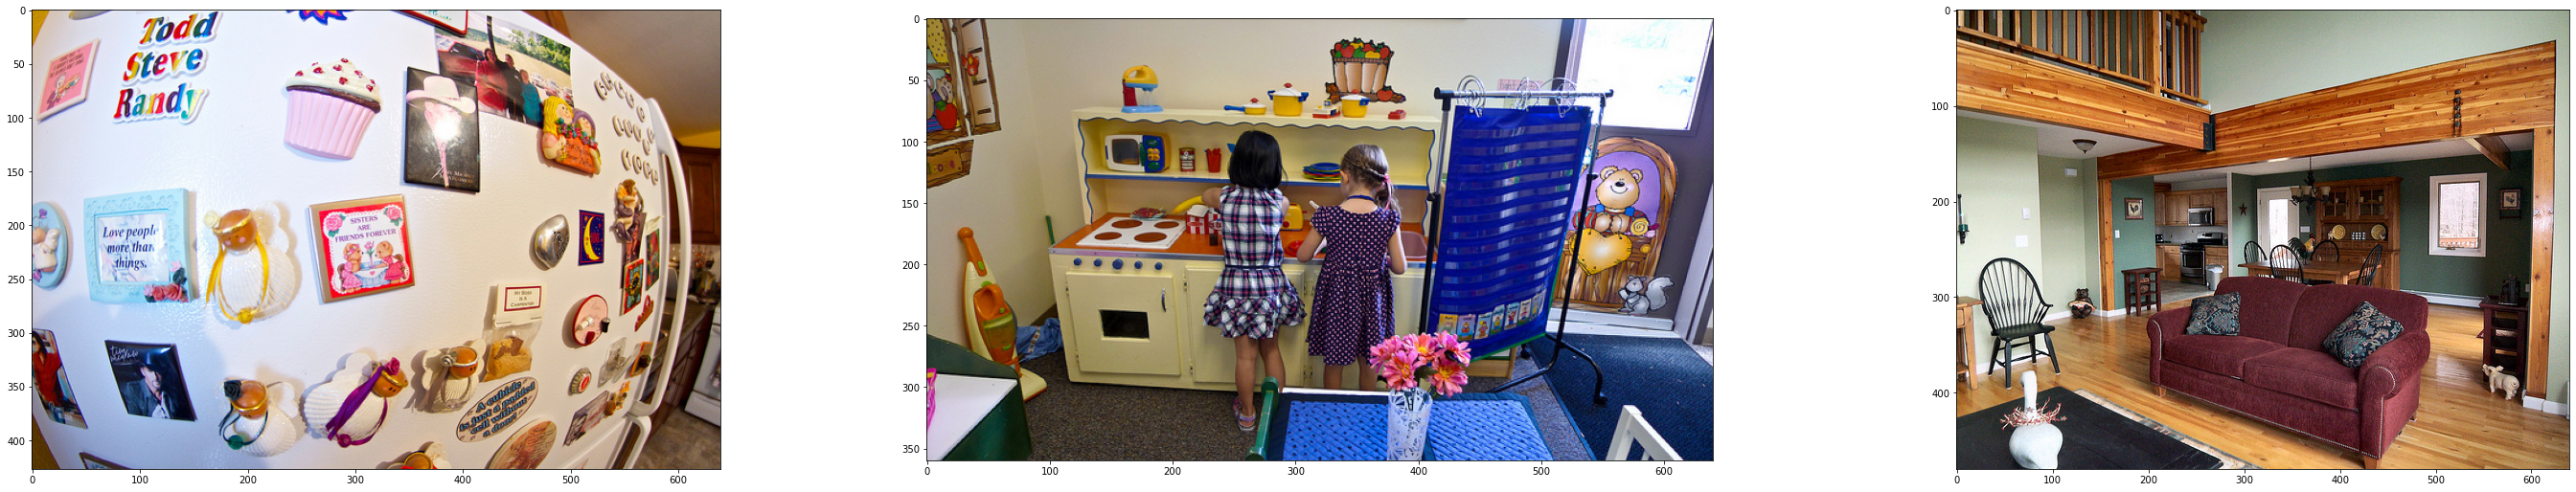

In [16]:
fig = plt.figure(1, figsize=(50, 30))
for i, img in enumerate(fetch_these_img_ids):
    fig.add_subplot(3, 3, i+1)
    img = coco.loadImgs(img)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
plt.show()

In [8]:
import torchvision
import albumentations as alb
from albumentations.pytorch import ToTensor, ToTensorV2
import numpy as np
import cv2


In [9]:
def resize_and_pad_img(img:np.ndarray, img_size=224):
    """
    :param img: image as np array (of either int or floats)
    :param img_size: pixels in output side length
    :return: image resized to img_size and converted to a square by adding padding
    """
    resize_and_pad_transform = alb.Compose(
        [
            alb.LongestMaxSize(
                max_size=img_size,
                interpolation=cv2.INTER_CUBIC,
            ),
            alb.PadIfNeeded(
                min_height=img_size,
                min_width=img_size,
                border_mode=cv2.BORDER_CONSTANT,
            ),
        ]
    )
    return resize_and_pad_transform(image=img).get('image')
def normalize_img(img:np.ndarray):
    """
    :param img: input image as np array
    :return: normalized image (convert from 0-255 RGB values to floats, then normalize by
    subtracting the mean and dividing by std deviation
    """
    return alb.Normalize(always_apply=True)(image=img).get('image')
def img_to_tensor(img:np.ndarray):
    """
    :param img: np image input
    :return: tensor representation of image
    """
    return alb.pytorch.ToTensorV2()(image=img).get('image')

In [36]:
img = "3.jpg"

In [37]:
img1 = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
print(img1)

[[[ 27  32  28]
  [ 28  34  30]
  [ 27  36  31]
  ...
  [ 66  93  52]
  [ 66  95  51]
  [ 67  96  50]]

 [[ 28  33  29]
  [ 27  33  29]
  [ 26  35  30]
  ...
  [ 66  93  52]
  [ 66  95  51]
  [ 67  96  50]]

 [[ 28  33  29]
  [ 27  33  29]
  [ 27  33  29]
  ...
  [ 66  93  50]
  [ 65  94  50]
  [ 66  95  49]]

 ...

 [[177 179 178]
  [176 178 177]
  [176 178 177]
  ...
  [182 187 190]
  [182 187 190]
  [181 186 189]]

 [[177 179 178]
  [177 179 178]
  [177 179 178]
  ...
  [182 187 190]
  [181 186 189]
  [181 186 189]]

 [[176 178 177]
  [177 179 178]
  [177 179 178]
  ...
  [182 187 190]
  [181 186 189]
  [181 186 189]]]


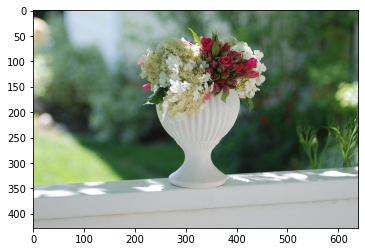

In [38]:
plt.imshow(img1)

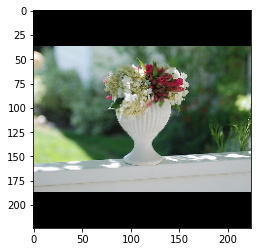

In [39]:
resize = resize_and_pad_img(img1)
plt.imshow(resize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


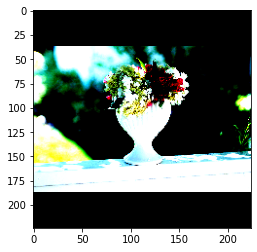

In [40]:
norm = normalize_img(resize)
plt.imshow(norm)

In [41]:
im_tensor = img_to_tensor(norm)
print(im_tensor.shape)

torch.Size([3, 224, 224])


In [9]:
import torch
import torchvision

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [3]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

Using cache found in /Users/mjamma/.cache/torch/hub/pytorch_vision_v0.10.0


In [4]:
model.eval()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
import torch.optim as optim
import torch.nn as nn
# Send the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()



Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

In [ ]:
import pycocotools
from pycocotools.coco import COCO
from PIL import Image

def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

train_data_dir = 'data/train'
train_coco = 'data/raw/train/annotations/instances_train2014.json'

class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))


    def __getitem__(self, index):
        
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        

        print(coco_annotation)
        return img, coco_annotation

my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )


In [ ]:
from os.path import isfile, join
from os import listdir
import numpy as np

batch_size = 64
num_workers = 4
train_data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers
                                         )

val_data_dir = 'data/raw/validation/val/'
val_coco = 'data/raw/train/annotations/instances_val2014.json'
val_dataset = myOwnDataset(root=val_data_dir,
                          annotation=val_coco,
                          transforms=get_transform()
                          )
val_data_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers
                                         )

test_dir = 'data/test/'

onlyfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]

test_images = []

for f in onlyfiles[:10000]:
    test_images.append(np.load(test_dir+f, allow_pickle=True))

test_loader = torch.utils.data.DataLoader(
    test_images, 
    batch_size=64,
    shuffle=True
)
    


In [ ]:
learning_rate = 0.001
momentum = 0.9
reg = 0.1

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                                momentum=momentum,
                                weight_decay=reg)
criterion = nn.CrossEntropyLoss()
model.classifier = nn.Linear(1024, 128)

def accuracy(output, target):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.shape[0]

    _, pred = torch.max(output, dim=-1)

    correct = pred.eq(target).sum() * 1.0

    acc = correct / batch_size

    return acc


def validate(epoch, val_loader, model):

    num_class = 10
    cm = torch.zeros(num_class, num_class)

    loss = 0

    #Citation: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
    model.eval()
    for idx, (data, target) in enumerate(val_loader):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        with torch.no_grad():
            out = model.forward(data)

        loss = criterion(out, target)


        batch_acc = accuracy(out, target)

        # update confusion matrix
        _, preds = torch.max(out, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
            cm[t.long(), p.long()] += 1

        losses.update(loss.item(), out.shape[0])
        acc.update(batch_acc, out.shape[0])

        iter_time.update(time.time() - start)
        if idx % 10 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
               'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t')
               .format(epoch, idx, len(val_loader), iter_time=iter_time, loss=losses, top1=acc))
    cm = cm / cm.sum(1)
    per_cls_acc = cm.diag().detach().numpy().tolist()
    for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

    print("* Prec @1: {top1.avg:.4f}".format(top1=acc))
    return acc.avg, cm

def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
    return train_loss

In [ ]:
best = 0.0
best_cm = None
best_model = None

epochs = 2

for epoch in range(epochs):
    train(model, train_data_loader, epoch)

        # validation loop
    #acc, cm = validate(epoch, test_loader, model)

    #if acc > best:
    #    best = acc
    #    best_cm = cm
    #    best_model = copy.deepcopy(model)

print('Best Prec @1 Acccuracy: {:.4f}'.format(best))